In [2]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [3]:
chrom = '22'
data_dir = '../split_gen_ihart'

In [4]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [5]:

# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# use only "cleaned" variants - must be SNPs
coordinates = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom))
snp_positions = coordinates[:, 1]
snp_indices = coordinates[:, 2]==1
snp_positions = snp_positions[snp_indices]

from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1004649


In [6]:
parent_indices = []
for inds in fam_to_inds.values():
    if inds[0] in sample_id_to_index:
        parent_indices.append(sample_id_to_index[inds[0]])
    if inds[1] in sample_id_to_index:
        parent_indices.append(sample_id_to_index[inds[1]])
print(len(parent_indices))

1984


In [19]:
parent_gen_counts = np.zeros((4, whole_chrom.shape[1]), dtype=int)
parent_gen_counts[1, :] = (whole_chrom[parent_indices, :]==1).sum(axis=0)
parent_gen_counts[2, :] = (whole_chrom[parent_indices, :]==2).sum(axis=0)
parent_gen_counts[3, :] = (whole_chrom[parent_indices, :]<0).sum(axis=0)
parent_gen_counts[0, :] = len(parent_indices) - np.sum(parent_gen_counts, axis=0)

nodel_norm = np.sum(parent_gen_counts[:3, :], axis=0)
parent_gen_counts_nodel = parent_gen_counts[:3, :]/nodel_norm # normalize
parent_gen_counts = parent_gen_counts/len(parent_indices) # normalize


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [8]:
parent_gen_counts_nodel[np.isnan(parent_gen_counts_nodel)] = 0

In [9]:
print(np.min(parent_gen_counts_nodel), np.max(parent_gen_counts_nodel))
print(np.min(parent_gen_counts), np.max(parent_gen_counts))

0.0 1.0
0.0 1.0


In [10]:
p_nodel = np.sqrt(parent_gen_counts_nodel[0, :])
q_nodel = 1 - p_nodel

0.0 1.0
0.0 1.0


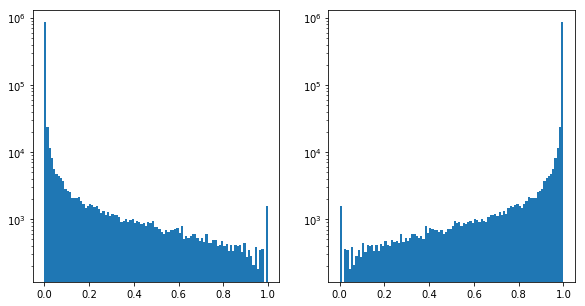

In [11]:
plt.figure(figsize=(15, 5))

print(np.min(q_nodel), np.max(q_nodel))
ax = plt.subplot(1, 3, 2)
plt.hist(q_nodel, bins=np.arange(0, 1.01, .01), log=True)

print(np.min(p_nodel), np.max(p_nodel))
plt.subplot(1, 3, 3, sharey=ax)
plt.hist(p_nodel, bins=np.arange(0, 1.01, .01), log=True)

plt.show()

In [12]:
r = np.sqrt(parent_gen_counts[3, :])
p = -r + np.sqrt(np.power(r, 2) + parent_gen_counts[0, :])
q = 1-r-p

0.0 1.0
0.0 1.0
0.0 1.0


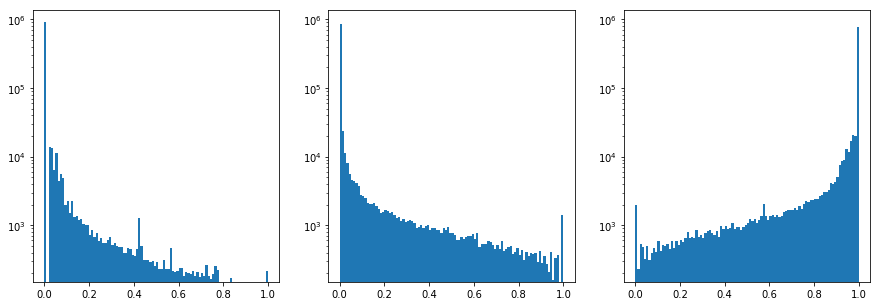

In [13]:
plt.figure(figsize=(15, 5))

print(np.min(r), np.max(r))
ax = plt.subplot(1, 3, 1)
plt.hist(r, bins=np.arange(0, 1.01, .01), log=True)

print(np.min(q), np.max(q))
plt.subplot(1, 3, 2, sharey=ax)
plt.hist(q, bins=np.arange(0, 1.01, .01), log=True)

print(np.min(p), np.max(p))
plt.subplot(1, 3, 3, sharey=ax)
plt.hist(p, bins=np.arange(0, 1.01, .01), log=True)

plt.show()

In [14]:
exp_nodel = np.zeros(parent_gen_counts_nodel.shape, dtype=float)
exp_nodel[0, :] = np.power(p_nodel, 2)
exp_nodel[1, :] = 2*p_nodel*q_nodel
exp_nodel[2, :] = np.power(q_nodel, 2)

exp = np.zeros(parent_gen_counts.shape, dtype=float)
exp[0, :] = np.power(p, 2) + 2*p*r
exp[1, :] = 2*p*q
exp[2, :] = np.power(q, 2) + 2*q*r
exp[3, :] = np.power(r, 2)

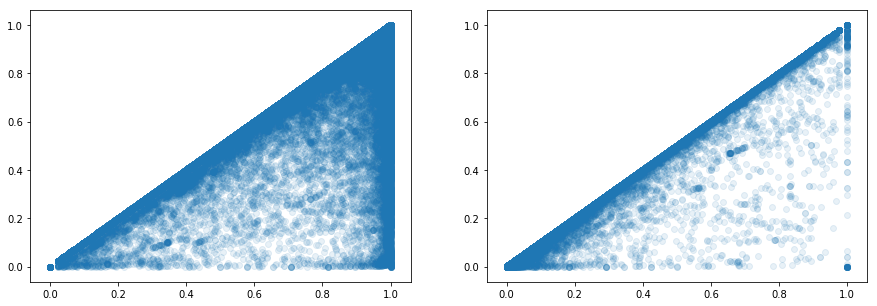

In [47]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(p_nodel, p, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(q_nodel, q, alpha=0.1)

plt.show()

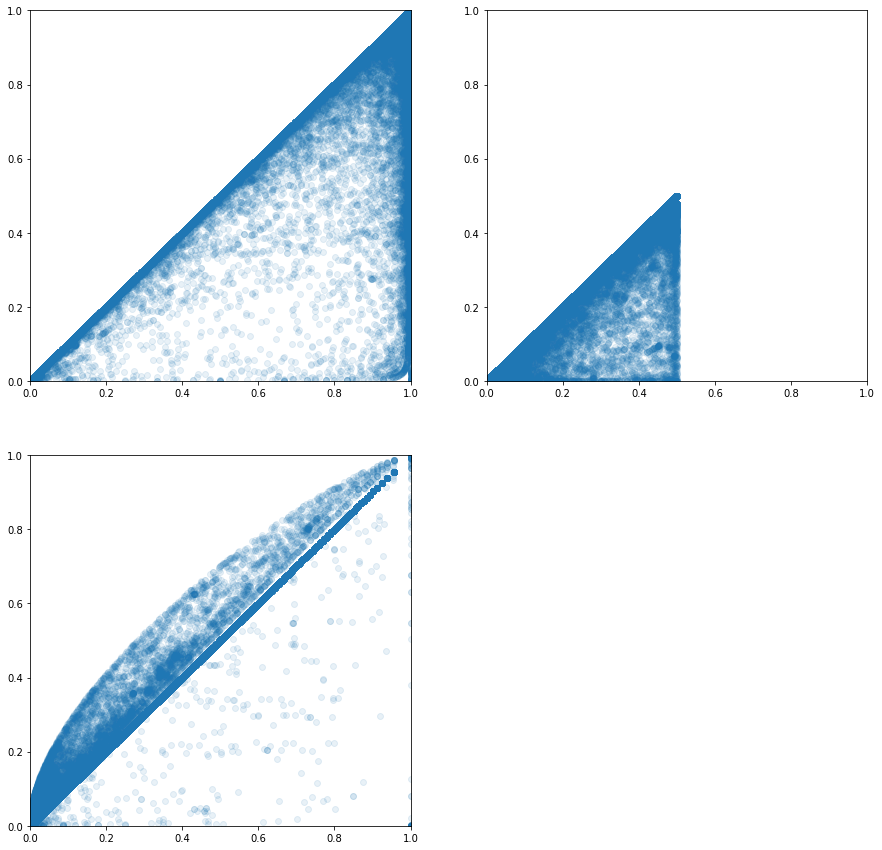

In [15]:
plt.figure(figsize=(15, 15))

for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.scatter(exp_nodel[i, :], exp[i, :], alpha=0.1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
plt.show()

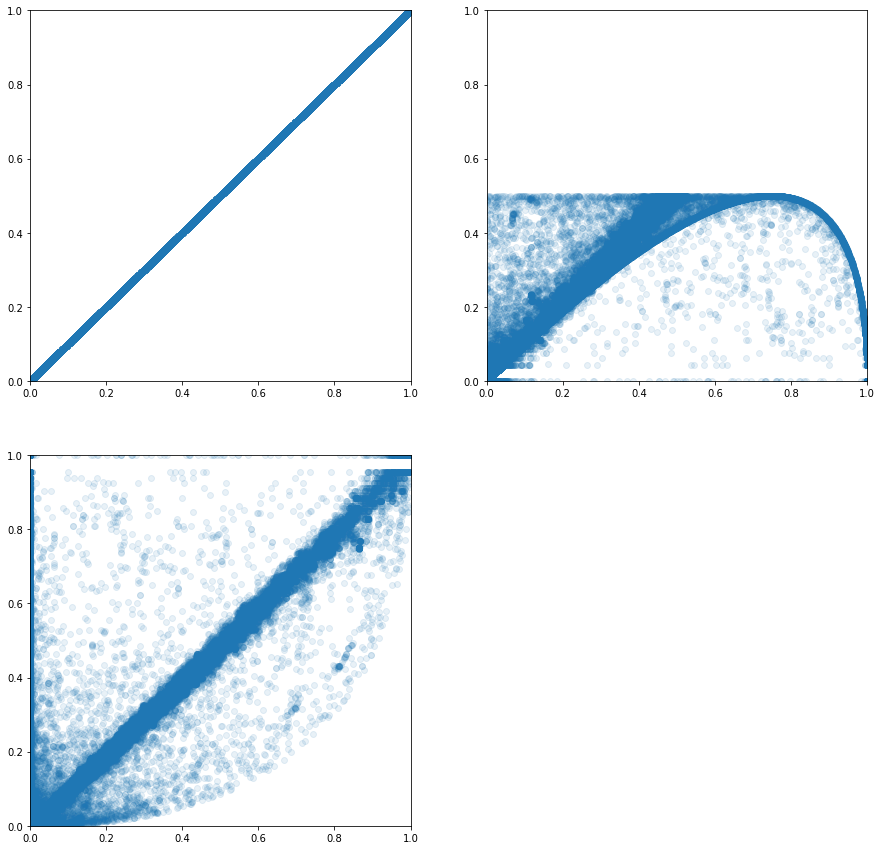

In [18]:
# the curve in plot 2 and the spike at 0 in plot 3 are due to positions where nearly all individuals have genotype=0/1
plt.figure(figsize=(15, 15))

for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.scatter(parent_gen_counts_nodel[i, :], exp_nodel[i, :], alpha=0.1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])


plt.show()

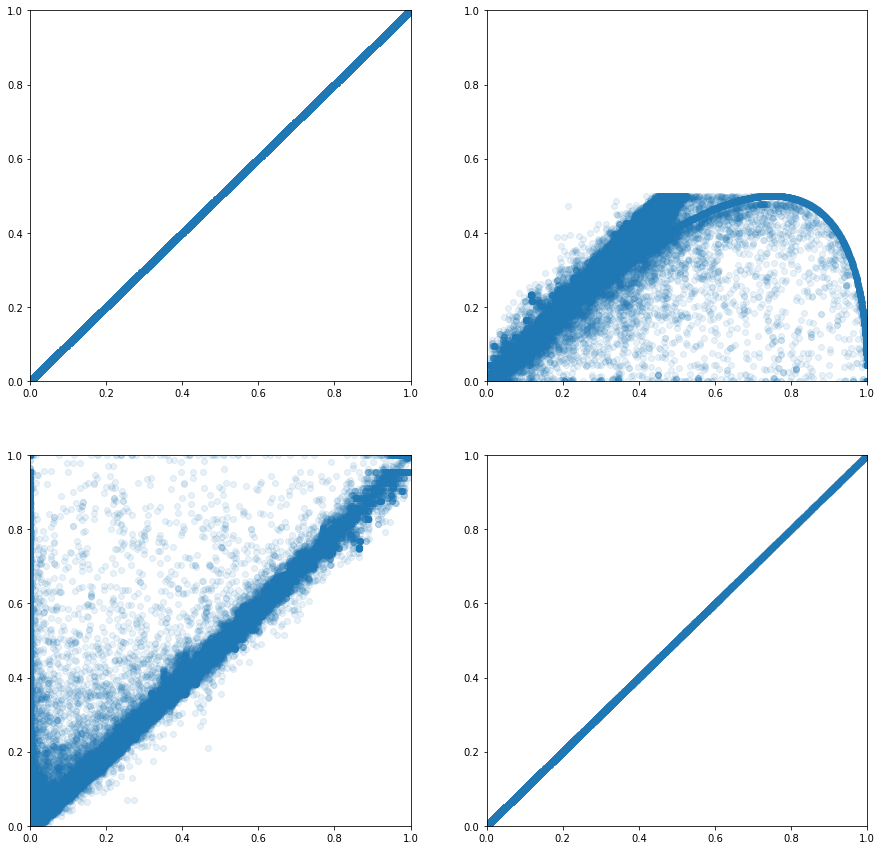

In [17]:
# the curve in plot 2 and the spike at 0 in plot 3 are due to positions where nearly all individuals have genotype=0/1
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(parent_gen_counts[i, :], exp[i, :], alpha=0.1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])


plt.show()

In [20]:
_, pvalue_nodel = scipy.stats.chisquare(nodel_norm*parent_gen_counts_nodel[1:3, :], nodel_norm*exp_nodel[1:3, :])

_, pvalue = scipy.stats.chisquare(len(parent_indices)*parent_gen_counts[1:3, :], len(parent_indices)*exp[1:3, :])



//anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
//anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
//anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


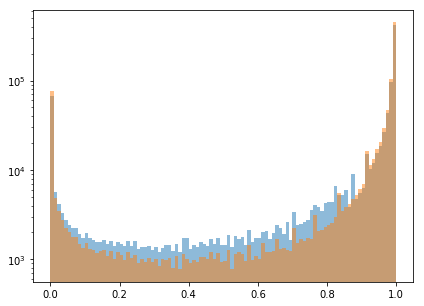

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(pvalue[~np.isnan(pvalue)], bins=np.arange(0, 1.01, .01), log=True, alpha=0.5)

plt.subplot(1, 2, 1)
plt.hist(pvalue_nodel[~np.isnan(pvalue_nodel)], bins=np.arange(0, 1.01, .01), log=True, alpha=0.5)
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


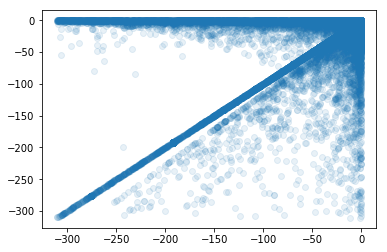

In [48]:
plt.scatter(np.log10(pvalue_nodel), np.log10(pvalue), alpha=0.1)
plt.show()

In [53]:
indices = ~np.isnan(pvalue) & \
    ~np.isnan(pvalue_nodel) & \
    (pvalue>(0.05/parent_gen_counts.shape[1]))


    #(q > 0.1) & (r != 0)

 #(pvalue_nodel<(0.05/parent_gen_counts.shape[1]))

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


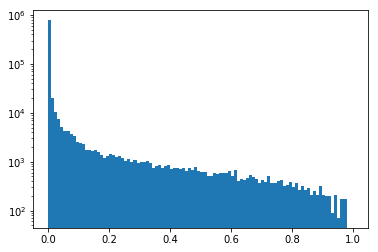

In [56]:
plt.hist(q[indices], bins=np.arange(0, 1.01, 0.01), log=True)
plt.show()

In [52]:
print('% positions', np.sum(indices)/indices.shape[0])
print('% missing', np.sum(parent_gen_counts[3, indices])/np.sum(parent_gen_counts[3, :]))

% positions 0.12432700376
% missing 0.0905119022149


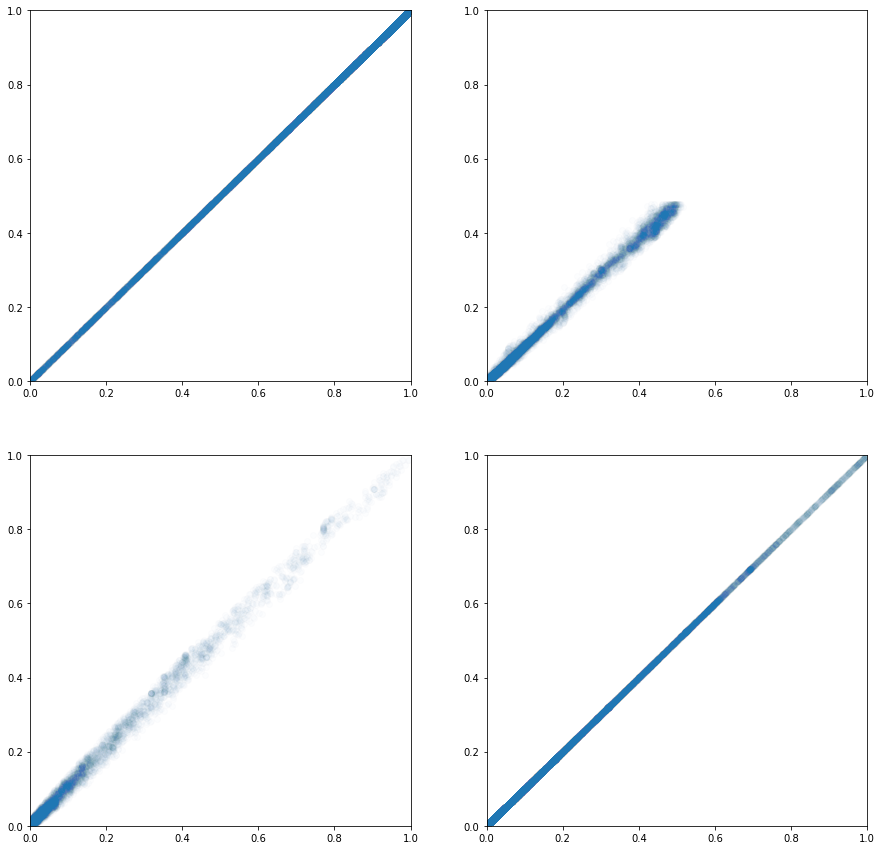

In [239]:
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(parent_gen_counts[i, indices], exp[i, indices], alpha=0.01)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.show()

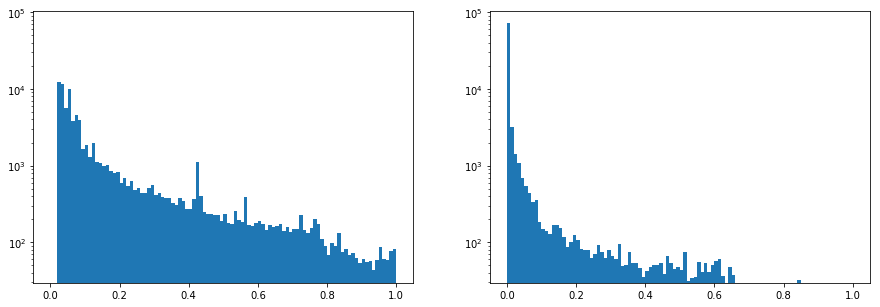

In [240]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.hist(r[indices], bins=np.arange(0, 1.01, .01), log=True)

plt.subplot(1, 2, 2, sharey=ax)
plt.hist(q[indices], bins=np.arange(0, 1.01, .01), log=True)

plt.show()

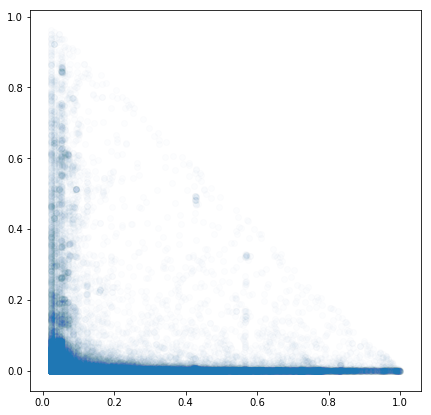

In [241]:
plt.figure(figsize=(7, 7))
plt.scatter(r[indices], q[indices], alpha=0.01)
plt.show()

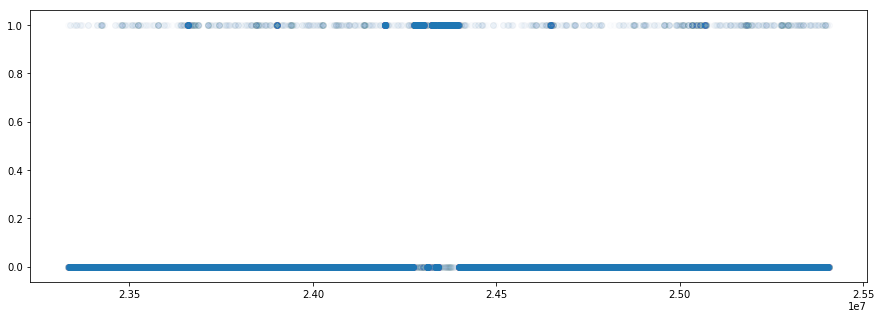

In [242]:
start, end = 24332998-1000000, 24406719+1000000

plt.figure(figsize=(15, 5))
plt.scatter(snp_positions[(snp_positions>=start) & (snp_positions<=end)], indices[(snp_positions>=start) & (snp_positions<=end)],
           alpha=0.01)
plt.show()

